### Import Libraries

In [1]:
import os
import tarfile
from six.moves import urllib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso,Ridge,ElasticNet,SGDRegressor,LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

sns.set(style="ticks", color_codes=True)

/home/moataz/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Loading Data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
 if not os.path.isdir(housing_path):
     os.makedirs(housing_path)
     tgz_path = os.path.join(housing_path, "housing.tgz")
     urllib.request.urlretrieve(housing_url, tgz_path)
     housing_tgz = tarfile.open(tgz_path)
     housing_tgz.extractall(path=housing_path)
     housing_tgz.close()

In [3]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
# fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH)

In [5]:
housing = load_housing_data(housing_path=HOUSING_PATH)

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


i don't think it's a good to have a feature total_rooms alone because it's doesn't make sense to have
total bedrooms in the district but i think we should combine total_rooms feature with households feature

### Exploring Data

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


All features numerical except ocean_proximity

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


1-total bedrooms has missing values
2-features:total rooms,total bedrooms,population,households,median_income 
  have right skewed (some outliers at right) but it's normally distrbuted mean ~ median
3-the most outlier features are population,total_rooms 
4-median_house_values well normally distributed

#### Visualising Data
Let's make sure that our intuation was right by Visualise data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc810561e50>,
      dtype=object)

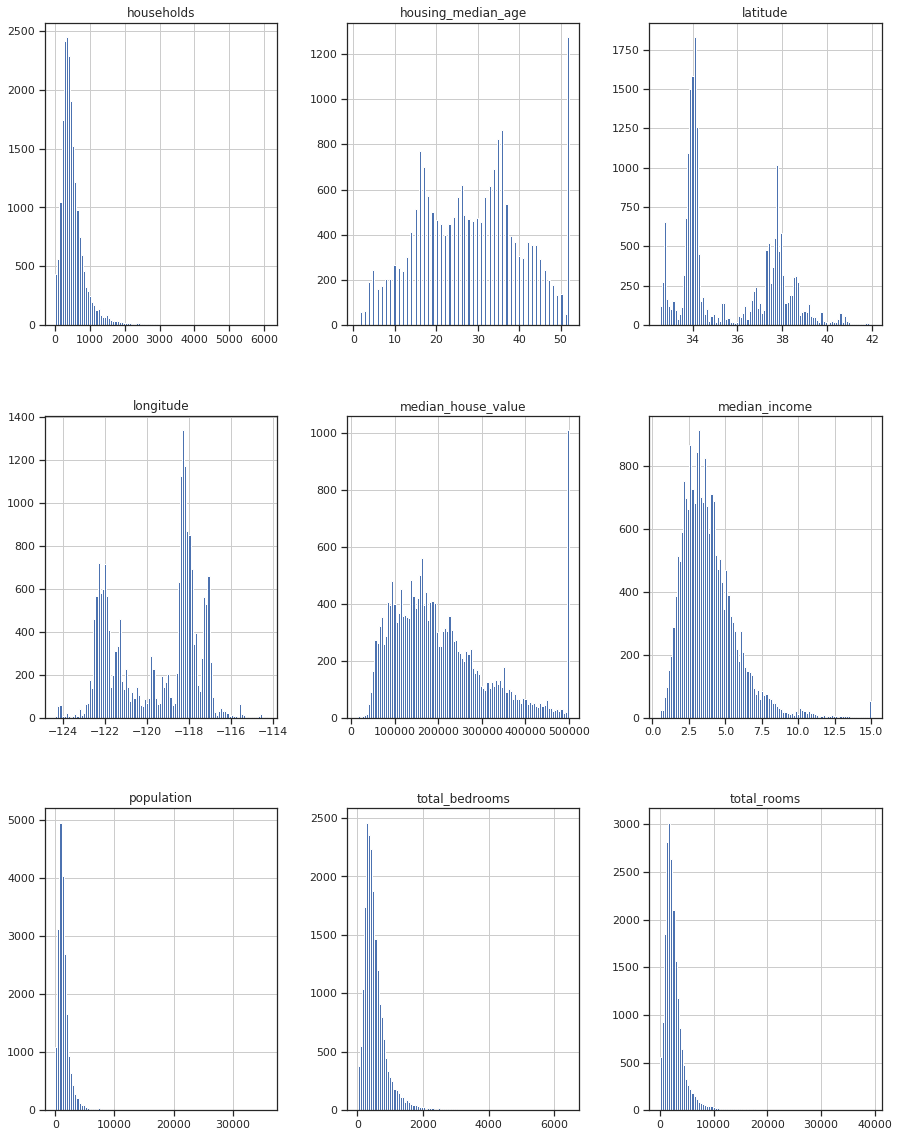

In [9]:
housing.hist(bins=100,figsize=(15,20))

Remove 1% quantile from population,total_rooms 

let's see how data is correlated with target value (median_house_value)

In [10]:
corr = housing.corr()
corr['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

median_income best correlated feature,
let's see how their plot with median_house_value

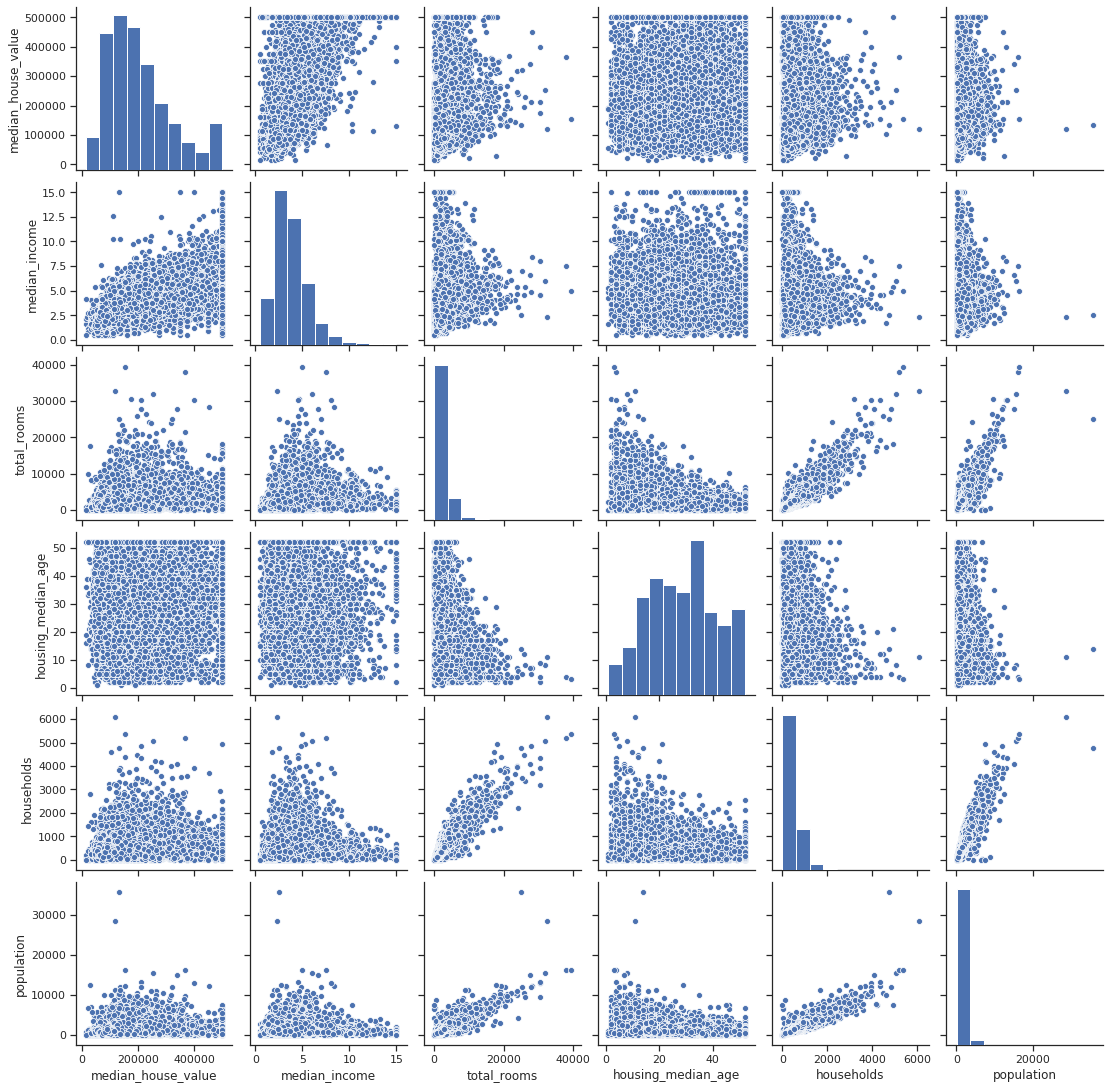

In [11]:
attributes_plot = ['median_house_value','median_income','total_rooms','housing_median_age','households',"population"]
sns.pairplot(housing[attributes_plot])

#### data not lineary with median housing income 
i expected that with longtitude and lattitude ofcourse it will be lineary but in 3D space because these 2 features
need to be mixed
but however other features not lineary 
so we need a nonlinear or model or linear model with combined features(polynomial degrees)

lets see how data correlated with each other by numbers to gain more intuative about collinarety between features

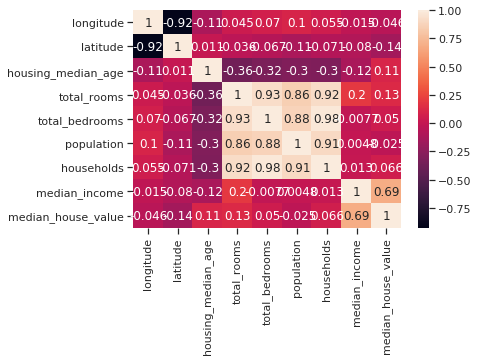

In [12]:
numerical_data = housing.drop('ocean_proximity',axis=1).corr()
sns.heatmap(numerical_data, annot=True)

In [13]:
corr['population'].sort_values(ascending=False)

population            1.000000
households            0.907222
total_bedrooms        0.877747
total_rooms           0.857126
longitude             0.099773
median_income         0.004834
median_house_value   -0.024650
latitude             -0.108785
housing_median_age   -0.296244
Name: population, dtype: float64

As we can see from heatmap population is correlated with other feature which won't working with linearRegression
this for sure won't be issue for other algorithms only LinearRegression 
however, but i will sure that assumption is violated (No multicollinearity) using VIF for more suspected features
after standrizescaling in data cleaning section

##### however linearRegression model won't be suited model because only one feature thats well correlated with data , i will be sured which feature are most important from random forest perspective in models section


### Data Cleaning

1- remove outliers

2- split num and cat features

3- handle numerical features

    handle missing values
    feature scaling

4- handle categorical values

In [14]:
housing_dc = housing.copy()

Handle outliers:
as we said there are several features has outliers [rooms,total bedrooms,population,households,median_income ]
but i will remove quantile 1% from the most confirmed features has outliers[population,total_rooms ]

In [15]:
q_population = housing_dc['population'].quantile(0.99)
housing_dc = housing_dc[housing_dc['population'] < q_population]

q_total_rooms = housing_dc['total_rooms'].quantile(0.99)
housing_dc = housing_dc[housing_dc['total_rooms'] < q_total_rooms]

In [16]:
comp_quantile = housing.describe().iloc[-1,:]
comp_quantile_df = pd.DataFrame(comp_quantile)
comp_quantile_df['max_after_cleaned'] = housing_dc.describe().iloc[-1,:]
comp_quantile_df

,max,max_after_cleaned
longitude,-114.3100,-114.3100
latitude,41.9500,41.9500
housing_median_age,52.0000,52.0000
total_rooms,39320.0000,9167.0000
total_bedrooms,6445.0000,2793.0000
population,35682.0000,5756.0000
households,6082.0000,2538.0000
median_income,15.0001,15.0001
median_house_value,500001.0000,500001.0000


As you could see values downs very rapidly after removing only 1% which only about 200 rows,but now without outliers

Handle Missing values:
1-replace with it's mean or median
2-remove all rows have missing values
3-remove the whole attribute

conculusion:
i cannot remove the whole attribute because only 207 missing out of 20640
i cannot remove all rows because there are other features it doesnt make sense to remove rows because only
one feature out of nine
sol: replace with it's mean or median
but i will use it in pipeline not seperated core

i'll use impute because for test data if any missing data it will replace with training set median.
however the code is:
###
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num_attrs)
X = imputer.transform(housing_num)
housing_cleaned = pd.DataFrame(X, columns=housing_num_attrs.columns)
###

Handle Feature Scaling
1-MinMax Scaler
2-StanderScaler
i'll use standerscaler because data still has outliers

i'll use also StandScaler in pipeline 

however here is the code:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(housing_num_attrs)

handle categorical values
two types of categorical encoding
1- OrdinalEncode 
2- OneHotEncoder (dummy)

In [17]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


As we could see [INLAND , NEAR OCEAN , NEAR BAY , ISLAND ]
not ordinal data like [low,medium,height] it's independent
so we will use OneHotEncoder

i will use it also in pipeline

code:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

### Feature Engineering

is it even data or feature representivie?
i think feature is representive because for sure number of rooms effect the price of house
also location(longitude , lattigude(
population yes it's effect price of house also
so all features i think they are representitive for pricing of house
but how about data , is it representivie?
may this sample give a low accuracy and another sample gives high accuracy
thanks to centeral limit theorim i will assume all samples are Normally distributed
but let's take intuation of data representivie the price


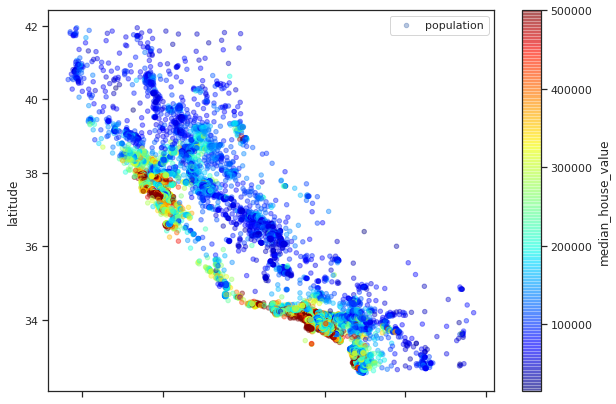

In [18]:
housing_dc.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

as i see this data has a pattern that prove it's representivie
but how pair plots or correlation of features with pricing not so much strong relation
ok there's is a solution
that's because these features not combined somehow
for example
what is the meaning of total number of rooms in distric or street
it may be more reasonable to say total number of rooms per house in street
then there will be a good correlation of tot_rooms/house with price
also alot of features has the same thing
we need to combine features !

let's see our assumption of features correlated with each other

In [19]:
variables = housing_dc[['population','households','total_rooms']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,15.918376,population
1,28.144783,households
2,16.914988,total_rooms


that's what i expected there are a strong relation between these variable
hint: i choosed these variable based on the pairplot of these 3 variable were shape of line
even these values of VIF > 5 should be deleted but must first standraized data

Solutions of feature selection
1- remove households for LinearRegression algorithm (no multicollinearity) but use it in Desiciontree or anyother
2- combine features manually 
    rooms_per_household= total_rooms/households
    bedrooms_per_room = total_bedrooms/total_rooms
    population_per_household = population / households
    
3- combine feature using polynomial feature (interaction_only=true)
4- combine features using high polynomial degree(degree=3)
5- pca (it may worsen the model)

i think best of them is number 3 solution because all features is related in somehow
but however we'll do a gridsearch and see which is best except for pca

In [20]:
#Combined Features:
#but if we did these last code then we need to do all these code again in test data and for new data so
#i will create class instead to do that automatic
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
     def __init__(self, strategy="manually"): # no *args or **kargs
         self.strategy = strategy
     def fit(self, X, y=None):
         return self # nothing else to do
     def transform(self, X, y=None):
        if(self.strategy=="manually"):
            rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
            population_per_household = X[:, population_ix] / X[:, households_ix]
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                    bedrooms_per_room]
        elif(self.strategy=="poly_interaction"):
            poly = PolynomialFeatures(interaction_only=True)
            return poly.fit_transform(X)
        elif(self.strategy=="poly_degree"):
            poly = PolynomialFeatures(2)
            return poly.fit_transform(X)


##### Pipelining data

In [21]:
X = housing_dc.drop("median_house_value", axis=1)
y = housing_dc["median_house_value"].copy()

In [22]:
#split num and cat features
housing_num_attrs = X.select_dtypes(include=['int64', 'float64']).columns
housing_cat_attrs = X.select_dtypes(include=['object']).columns

### Train test split

In [23]:
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [24]:
print("X Train shape",X_train.shape)
print("Y Train shape",y_train.shape)
print("x Test shape",X_test.shape)
print("y Test shape",y_test.shape)

X Train shape (16182, 9)
Y Train shape (16182,)
x Test shape (4046, 9)
y Test shape (4046,)


In [25]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('attribs_adder', CombinedAttributesAdder(strategy="poly_degree")),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, housing_num_attrs),
        ('cat', categorical_transformer, housing_cat_attrs)])

In [26]:
X_train.shape[1:]

(9,)

In [27]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

In [28]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(200),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(200),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(1)
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 200)               2800      
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               8

In [30]:
#Tensorboard Visualization
import os
root_logdir = os.path.join(os.curdir, "housing_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

In [31]:
Adam_optimizer = keras.optimizers.Adam(lr=0.01, decay=1e-4)
model.compile(loss="mean_squared_error",optimizer=Adam_optimizer,metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [32]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("keras_housing.h5",save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=150,validation_split=0.1,callbacks=[early_stopping_cb,checkpoint_cb,tensorboard_cb])

Train on 14563 samples, validate on 1619 samples
Epoch 1/150
14563/14563 [==============================] - 2s 132us/sample - loss: 53756598560.9954 - root_mean_squared_error: 231854.7031 - val_loss: 49441547277.2823 - val_root_mean_squared_error: 222354.5625
Epoch 2/150
14563/14563 [==============================] - 1s 82us/sample - loss: 43746015094.4635 - root_mean_squared_error: 209155.4688 - val_loss: 36296784791.6393 - val_root_mean_squared_error: 190517.1406
Epoch 3/150
14563/14563 [==============================] - 1s 81us/sample - loss: 30039049827.8476 - root_mean_squared_error: 173317.7656 - val_loss: 22920000775.7480 - val_root_mean_squared_error: 151393.5312
Epoch 4/150
14563/14563 [==============================] - 1s 81us/sample - loss: 18266482829.8257 - root_mean_squared_error: 135153.5312 - val_loss: 13662380679.6689 - val_root_mean_squared_error: 116886.1953
Epoch 5/150
14563/14563 [==============================] - 1s 80us/sample - loss: 10908548274.2490 - root_mean

In [34]:
y_hat_test = model.predict(X_test)
mse = mean_squared_error(y_test, y_hat_test)
rmse = np.sqrt(mse) 
rmse

54542.236407526114

In [ ]:
#RandomForest better than NN or i just didn't found the right parameters